<a href="https://colab.research.google.com/github/Lor3nzoVis3/DeepLearning_ProjectLV_GB/blob/master/TransferLearningV3_faceOrientation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
"""
@authors: LorenzoVisentini and Gianmarco Bolcato
"""

modelName = "InceptionV3"

#import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#keras
import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras_adabound import AdaBound

#inception v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.utils import plot_model

import random
random.seed(42)

Using TensorFlow backend.


In [4]:
# link with Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Images parameters
img_target_size = (299, 299)
shape = (299, 299, 3)

# Jupyter notebook paths
train_dir = './orient/train'
val_dir = './orient/val' 
test_dir = './orient/test' 

# Google Colab paths
# train_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/orient/train'
# val_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/orient/val' 
# test_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/orient/test' 

In [6]:
n_classes = 3

# Hyperparameters
batch_size = 32
epochs = 15
drop_rate = 0.55
lr = 0.003

# variable to check if it's applied the batchNormalization patch
patch = True

# Set aug variable to save if the model used data augmentation or not
aug = True
if aug == True:
    modelName = modelName+'Aug'

file_model = modelName + 'ABound_OR' + '_Bs' + str(batch_size) + '_Ep' + str(epochs) + '_Dr' + str(drop_rate) + '_Lr' + str(lr)
if patch == True:
    file_model = file_model + '_patched'

In [7]:
# Transfer learning on InceptionV3 model
# use all the layers except for the last fully connected layer (because its 
# specific to the ImageNet competition)
# we will retrain layers with new inputs
pre_trained_model = InceptionV3(input_shape = shape,
                               include_top = False, #exclude last flatten layer
                               weights = 'imagenet' #weights from imageNet
                               ) 

# pre_trained_model.summary() #check V3 structure

In [8]:
# transfer learning phase
x = pre_trained_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation= 'relu')(x) 
x = Dropout(drop_rate)(x)
x = Dense(128, activation= 'relu')(x) #add fully connected layer
x = Dropout(drop_rate)(x)
x = Dense(n_classes, activation= 'softmax')(x)
model = Model(inputs = pre_trained_model.input, outputs = x)

#freeze the model excepted added layers

# for layer in pre_trained_model.layers:
#     layer.trainable = False

#because of BN normalization problem: https://github.com/keras-team/keras/issues/9214
for layer in pre_trained_model.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
            layer.trainable = True
            K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
            K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
        else:
            layer.trainable = False
            
# custom optimizer
# opt = optimizers.Adam(learning_rate=lr)
# AdaBound(lr=lr)

model.compile(optimizer = AdaBound(lr=lr),
              loss = 'categorical_crossentropy',  #because we have 3 possible outputs
              metrics = ['accuracy'])

In [9]:
# plot model tree
tree_path = './ModelTrees/'
# tree_path = '/content/drive/My Drive/Deep Learning Project - Image Classification/ModelTrees' 

if os.path.exists(tree_path) == False:
    os.makedirs(tree_path)
else: 
    print('Folder Plots already exists')
plot_model(model, to_file=f"{tree_path}/{file_model}.png", show_layer_names=True, show_shapes=True)

Folder Plots already exists


In [10]:
# Preprocessing

train_gen = ImageDataGenerator(width_shift_range=[0,0.2],
                            height_shift_range=[0,0.2],
                            zoom_range=[0.8,1.0],
                            fill_mode="nearest")
# train_gen = ImageDataGenerator()

test_gen = ImageDataGenerator()    

train_generator = test_gen.flow_from_directory(directory=train_dir,
                                                    target_size=img_target_size,
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

val_generator = test_gen.flow_from_directory(directory=val_dir,
                                                    target_size=img_target_size,
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

test_generator = test_gen.flow_from_directory(directory = test_dir,
                                                    target_size = img_target_size,
                                                    color_mode="rgb",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle=True,
                                                    seed=42
                                                )
# DONT PUT SHUFFLE = FALSE

Found 7135 images belonging to 3 classes.
Found 1529 images belonging to 3 classes.
Found 1530 images belonging to 3 classes.


In [11]:
# History
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = train_generator.n//batch_size,
                             epochs = epochs,
                             validation_data = val_generator,
                             validation_steps=val_generator.n//batch_size
                             )

Epoch 1/15
222/222 [==============================] - 129s 581ms/step - loss: 1.0863 - accuracy: 0.5524 - val_loss: 0.7604 - val_accuracy: 0.6483
Epoch 2/15
222/222 [==============================] - 110s 495ms/step - loss: 0.7803 - accuracy: 0.6518 - val_loss: 0.5016 - val_accuracy: 0.6921
Epoch 3/15
222/222 [==============================] - 108s 486ms/step - loss: 0.7077 - accuracy: 0.6724 - val_loss: 0.5849 - val_accuracy: 0.7021
Epoch 4/15
222/222 [==============================] - 108s 488ms/step - loss: 0.6662 - accuracy: 0.7041 - val_loss: 0.5303 - val_accuracy: 0.6740
Epoch 5/15
222/222 [==============================] - 108s 487ms/step - loss: 0.6546 - accuracy: 0.6935 - val_loss: 0.6081 - val_accuracy: 0.7041
Epoch 6/15
222/222 [==============================] - 108s 487ms/step - loss: 0.6235 - accuracy: 0.7193 - val_loss: 0.7316 - val_accuracy: 0.7108
Epoch 7/15
222/222 [==============================] - 109s 491ms/step - loss: 0.6111 - accuracy: 0.7277 - val_loss: 0.7079 -

In [14]:
# consider highlight the different values of hyperparameters used
# OR orient o SL source light, Bs batch size, Ep epochs, Dr drop rate, Lr learning rate
# CHECK ALWAYS BOOLEAN PATCH VALUES (on top)

# Save model
# create models folder if doesn't exist
path_models = './Models/'
# path_models = '/content/drive/My Drive/Deep Learning Project - Image Classification/Models/' 

if os.path.exists(path_models) == False:
    os.makedirs(path_models)
else: 
    print('Folder Models already exists')

model.save(path_models + file_model + '.h5')
print(file_model)


# Save history
# create models folder if doesn't exist
path_history = './History/'
# path_history = '/content/drive/My Drive/Deep Learning Project - Image Classification/History/' 

if os.path.exists(path_history) == False:
    os.makedirs(path_history)
else: 
    print('Folder History already exists')
file_hist = path_history + file_model + '.csv'
df_history = pd.DataFrame(history.history)
with open(file_hist, 'w') as file:
    df_history.to_csv(file)
print(file_hist)

Folder Models already exists
InceptionV3AugABound_OR_Bs32_Ep15_Dr0.55_Lr0.003_patched
Folder History already exists
./History/InceptionV3AugABound_OR_Bs32_Ep15_Dr0.55_Lr0.003_patched.csv


C:\Users\Sviluppo\anaconda3\envs\deeplearning\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Folder Plots already exists


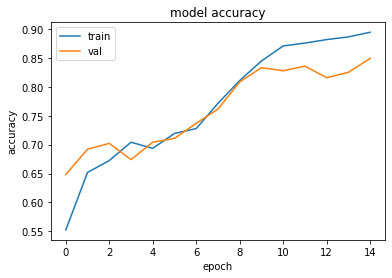

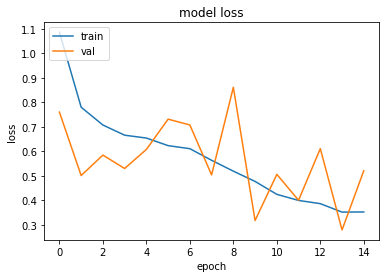

In [12]:
# Plot path
plot_path = './Plots/'
# plot_path = '/content/drive/My Drive/Deep Learning Project - Image Classification/History/' 

if os.path.exists(plot_path) == False:
    os.makedirs(plot_path)
else: 
    print('Folder Plots already exists')
plot_file = file_model + '.jpg'


# plot results
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.savefig(plot_path + 'Accuracy' + plot_file)

plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.savefig(plot_path + 'Loss' + plot_file)

plt.show()

In [13]:
# Predict
steps = test_generator.n // test_generator.batch_size
accuracy_ontest = model.evaluate_generator(test_generator, steps)
print(accuracy_ontest)

[0.3000621795654297, 0.8603723645210266]
